# Body curve ANOVA and posthoc by plate
Conny Lin | May 3, 2020 | updated: May 9, 2020

In [35]:
# - plan - 
# get csv by plate
# export descriptive csv for excel graphing
# transform to anova input
# run anova
# run posthoc
# put in table
# visualize differences between groups

In [36]:
# import library
# import libraries
import os
import re as re
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
from scipy.stats import norm #used for plotting
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.anova import anova_lm
from statsmodels.stats import multicomp
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [37]:
# functions
def report_stats_apa(stattype,dfreedom,testresult,pvalue,plimit=0.001,alpha=0.05):
    if pvalue<plimit:
        stat_report_str = print(f'{stattype}({dfreedom:.0f}) = {testresult:.3f}, p < {plimit}')
    elif p>alpha:
        stat_report_str = print(f'{stattype}({dfreedom:.0f}) = {testresult:.3f}, p = n.s.')
    else:
        stat_report_str = print(f'{stattype}({dfreedom:.0f}) = {testresult:.3f}, p = {pvalue:.3f}')
    return stat_report_str

In [38]:
def convert_statsmodel_table2dataframe(statsmodel_object):
    column_names = statsmodel_object.data[0]
    d = statsmodel_object.data[1:]
    statsmodel_object_dataframe = pd.DataFrame(d,columns=column_names)
    return statsmodel_object_dataframe

## work

In [39]:
# set working dir
working_dir = '/Users/connylin/Dropbox/CA/CA Publications/Manuscript RL Alcohol hab model slo1/3-Results/Fig1 WT speed and curve before training dose/basal_response_by_exp_20200418/'

In [40]:
# global variable
alpha = 0.05
pvlimit = 0.001

In [41]:
# get csv by plate
p = os.path.join(working_dir, 'desc_stats_by_plate.csv')
df = pd.read_csv(p)
df.head()

,expyear,expname,groupname,mwtname,wormN,speed,speed_SE,curve,curve_SE
0,2012,20120213C_FP_100s30x10s10s_DoseDependency,N2_100mM,20120213_154120,9,0.307969,0.019229,26.808175,0.615400
1,2012,20120213C_FP_100s30x10s10s_DoseDependency,N2_100mM,20120213_155059,15,0.264298,0.016657,31.725721,0.972318
2,2012,20120213C_FP_100s30x10s10s_DoseDependency,N2_100mM,20120213_155939,24,0.285712,0.013011,30.255534,0.387169
3,2012,20120213C_FP_100s30x10s10s_DoseDependency,N2_100mM,20120213_161324,25,0.362677,0.015299,29.494326,0.535562
4,2012,20120213C_FP_100s30x10s10s_DoseDependency,N2_200mM,20120213_162924,26,0.299793,0.015675,24.495509,0.705827


In [42]:
# export descriptive csv for excel graphing
df1 = df.groupby('groupname').aggregate({'curve':['mean','sem','count']})
df1.to_csv(os.path.join(working_dir,'curve_desc_bygroup_Nplate.csv'))
display(df1)
del df1

curve                
                mean       sem count
groupname                           
N2         33.451397  0.440895    16
N2_100mM   29.546363  0.413260    15
N2_200mM   25.217900  0.500423    20
N2_300mM   22.180410  0.491802    15
N2_400mM   21.012105  0.906346    15
N2_500mM   19.166218  0.415679    16
N2_600mM   19.390700  0.425215     8

In [43]:
# transform to anova input - no need. already in the format

In [44]:
# run anova
df_lm = ols('curve ~ groupname', data=df).fit()
anovaT = anova_lm(df_lm)
display(anovaT)

,df,sum_sq,mean_sq,F,PR(>F)
groupname,6.0,2597.760324,432.960054,93.752948,2.316218e-38
Residual,98.0,452.573345,4.618095,NaN,NaN


In [45]:
# export anova table
anovaT.to_csv(os.path.join(working_dir,'curve_desc_bygroup_Nplate_anovatable.csv'))

In [46]:
# get anova written report format
anova_apa = report_stats_apa('F',
                             anovaT.loc['groupname','df'],
                             anovaT.loc['groupname','F'],
                             anovaT.loc['groupname','PR(>F)'],
                             pvlimit,
                             alpha)
anova_apa

F(6) = 93.753, p < 0.001


In [47]:
# run posthoc
tukey = multicomp.pairwise_tukeyhsd(df['curve'], df['groupname']).summary()
tukey

group1,group2,meandiff,p-adj,lower,upper,reject
N2,N2_100mM,-3.905,0.001,-6.23,-1.58,True
N2,N2_200mM,-8.2335,0.001,-10.4033,-6.0637,True
N2,N2_300mM,-11.271,0.001,-13.596,-8.946,True
N2,N2_400mM,-12.4393,0.001,-14.7643,-10.1143,True
N2,N2_500mM,-14.2852,0.001,-16.5724,-11.998,True
N2,N2_600mM,-14.0607,0.001,-16.8619,-11.2595,True
N2_100mM,N2_200mM,-4.3285,0.001,-6.5381,-2.1188,True
N2_100mM,N2_300mM,-7.366,0.001,-9.7282,-5.0037,True
N2_100mM,N2_400mM,-8.5343,0.001,-10.8965,-6.172,True
N2_100mM,N2_500mM,-10.3801,0.001,-12.7052,-8.0551,True


In [48]:
# put in table
tukey_df = convert_statsmodel_table2dataframe(tukey)
tukey_df.to_csv(os.path.join(working_dir,'curve_desc_bygroup_Nplate_tukeytable.csv'))

In [49]:
# visualize differences between groups
# transform to seaborn heatmap input
tukey_df_pvalue_pivot = tukey_df.pivot(index='group1',columns='group2',values='p-adj')
tukey_df_pvalue_pivot

group2,N2_100mM,N2_200mM,N2_300mM,N2_400mM,N2_500mM,N2_600mM
group1,,,,,,
N2,0.001,0.001,0.0010,0.0010,0.0010,0.0010
N2_100mM,NaN,0.001,0.0010,0.0010,0.0010,0.0010
N2_200mM,NaN,NaN,0.0014,0.0010,0.0010,0.0010
N2_300mM,NaN,NaN,NaN,0.7239,0.0032,0.0564
N2_400mM,NaN,NaN,NaN,NaN,0.2140,0.5885
N2_500mM,NaN,NaN,NaN,NaN,NaN,0.9000


In [50]:
# mute n.s.
tukey_df_graphing = tukey_df_pvalue_pivot.mask(tukey_df_pvalue_pivot > alpha)
tukey_df_graphing

group2,N2_100mM,N2_200mM,N2_300mM,N2_400mM,N2_500mM,N2_600mM
group1,,,,,,
N2,0.001,0.001,0.0010,0.001,0.0010,0.001
N2_100mM,NaN,0.001,0.0010,0.001,0.0010,0.001
N2_200mM,NaN,NaN,0.0014,0.001,0.0010,0.001
N2_300mM,NaN,NaN,NaN,NaN,0.0032,NaN
N2_400mM,NaN,NaN,NaN,NaN,NaN,NaN
N2_500mM,NaN,NaN,NaN,NaN,NaN,NaN


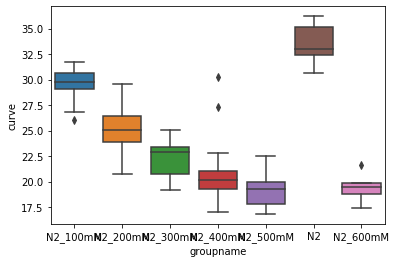

In [51]:
# bar chart
sns.boxplot(x='groupname',y='curve',data=df)

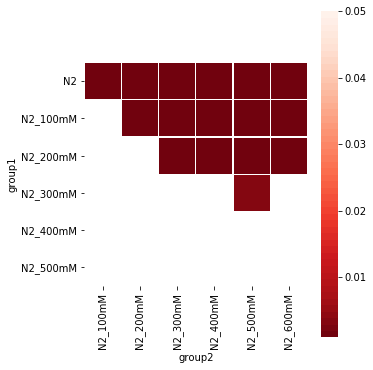

In [52]:
# visualize
plt.figure(figsize=(5,6))
cmap = sns.color_palette("Reds_r", 50)
sns.heatmap(tukey_df_graphing,cmap=cmap,square=True,linewidth=0.2,vmin=pvlimit,vmax=alpha)
plt.savefig(os.path.join(working_dir,'curve_desc_bygroup_Nplate_tukeytable.jpeg'))